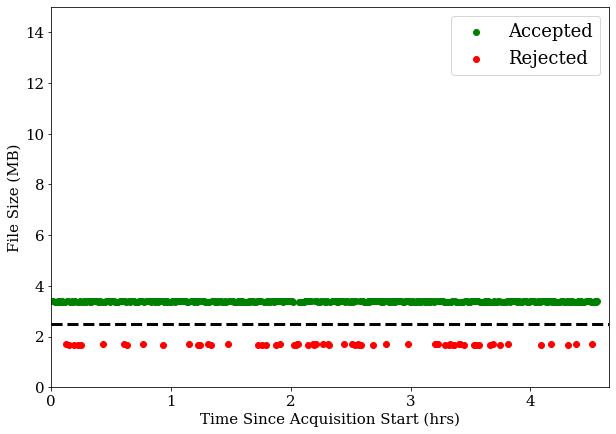

In [63]:
import numpy as np
from numpy import random
import json
import scipy as sp
from scipy import signal
from numpy.matlib import repmat
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from sklearn import mixture
import glob
import os
import importlib
import sys
import uproot
import time
import MiXHelper20230317 as MiXHelper
importlib.reload(MiXHelper)

ts = 15
params = {'legend.fontsize': 'large',
          'font.family': 'serif',
          'figure.figsize': (10,7),
          'axes.labelsize': ts,
          'axes.titlesize': ts,
          'xtick.labelsize': ts,
          'ytick.labelsize': ts}
plt.rcParams.update(params)

###########################################change##############################################
#path of reduced data
filePath = '/nfs/turbo/lsa-MiXturbo/MiX-2023-data/reducedData/20230123/Cs137_C3500_G3000_616_692_634_625_1136_tSumTrigger/'
#path of raw data files
rawPath = '/nfs/turbo/lsa-MiXturbo/MiX-2023-data/MiXData/20230123/Cs137_C3500_G3000_616_692_634_625_1136_tSumTrigger/'
#path of gain file
gainFile = '/nfs/turbo/lsa-MiXturbo/MiX-2023-analysis/20230120/gainparams20230123.csv'
#path of analysis params file
aparFile = '/nfs/turbo/lsa-MiXturbo/MiX-2023-analysis/20230120/AnalysisParams20230120.json'
###############################################################################################

fileNames = MiXHelper.getFileList(filePath, '*.root')
fileSizes = MiXHelper.getFileSizes(fileNames)
fileTimes = MiXHelper.getFileUnixTimes(fileNames, relative = True)

rawNames = MiXHelper.getFileList(rawPath, '*.root')

###########################################change##############################################
fileCut = 2.5e6
###############################################################################################
fileMask = fileSizes >= fileCut
fileReject = np.invert(fileMask)

plt.figure()
plt.scatter(fileTimes[fileMask]/3600, fileSizes[fileMask]/1e6, c = 'green', label = 'Accepted')
plt.scatter(fileTimes[fileReject]/3600, fileSizes[fileReject]/1e6, c = 'red', label = 'Rejected')
plt.plot([0, fileTimes[-1]/3600 + 0.1], [fileCut/1e6, fileCut/1e6], 'k--', linewidth = 3)
plt.xlim([0, fileTimes[-1]/3600 + 0.1])
plt.ylim([0, 15])
plt.xlabel('Time Since Acquisition Start (hrs)')
plt.ylabel('File Size (MB)')
plt.legend(fontsize = 18, loc = 'upper right')
plt.show()

with open(aparFile) as paramsFile:
    
    paramsData = json.load(paramsFile)
    RQs = paramsData['RQs']
    
    dVperAdc = paramsData['dVperAdc']
    resistance = paramsData['resistance']
    samplingFreq = paramsData['samplingFreq']
    voltages = paramsData['voltages']
    
    PEThreshold = paramsData['PEThreshold']
    baselineSamples = paramsData['baselineSamples']
    absoluteSpacing = paramsData['absoluteSpacing']
    relativeSpacing = paramsData['relativeSpacing']
    cartCoor = paramsData['cartCoor']

#fixes issue where some files don't get reduced for whatever reason
fileNamesTime = np.array([name[126:] for name in fileNames])
rawNamesClean = np.array([])
for i in range(len(rawNames)):
    Name = rawNames[i][122:]
    if Name in fileNamesTime:
        rawNamesClean = np.append(rawNamesClean,rawNames[i])
        
selFiles = fileNames[fileMask]
rawFiles = rawNamesClean[fileMask]

mV = dVperAdc*1000
gains  = MiXHelper.calcGains(voltages,gainFile)
PE = MiXHelper.scaleToPE(dVperAdc, resistance, samplingFreq, gains)

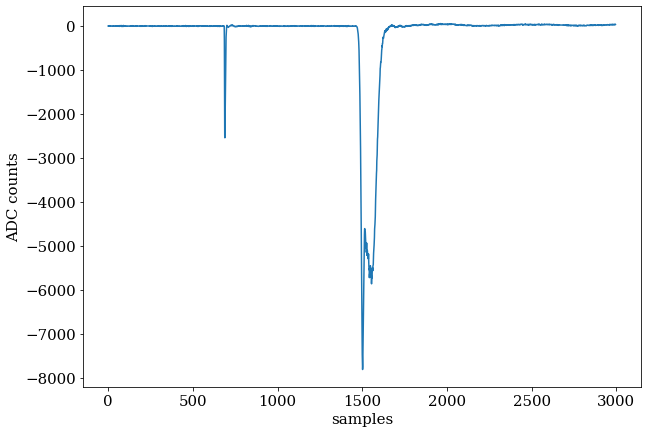

In [67]:
MiXHelper.ViewEvent(selFiles,rawFiles,RQs,200,217,scale=PE,)